# Modelo de Aprendizaje Automático:

Después de completar el Análisis Exploratorio de Datos (EDA) para comprender la naturaleza de nuestros datos, avanzamos hacia la creación de un modelo de recomendación basado en la similitud del coseno.
El enfoque del modelo se fundamenta en la similitud entre juegos. Al proporcionar el nombre o identificador de un juego específico, el sistema generará una lista de 5 juegos recomendados que comparten similitudes con el juego de referencia. Esta metodología es ideal para usuarios que buscan descubrir títulos relacionados o similares a sus juegos preferidos.

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Cargamos nuestro datos 

In [6]:
df_output = pd.read_csv("data2/output_steam_games_limpio9.csv")
df_items = pd.read_csv("data2/user_items_limpio5.csv")
df_reviews = pd.read_csv("data2/user_reviews_limpio7.csv")

In [124]:
df_output.columns

Index(['app_name', 'id', 'developer', 'price_number', 'release_year',
       'main_genre'],
      dtype='object')

In [68]:
df_reviews.columns

Index(['user_id', 'item_id', 'recommend', 'year_posted', 'sentiment_analysis'], dtype='object')

In [69]:
df_items.columns

Index(['user_id', 'items_count', 'item_id', 'item_name', 'playtime_forever'], dtype='object')

## 1. Definición del Puntaje de Recomendación
En esta etapa, definimos el puntaje de recomendación ('Recommendation') que guiará nuestras recomendaciones. Este puntaje, en una escala del 1 al 5, combina el análisis de sentimiento de las reseñas y las recomendaciones de los usuarios.

In [4]:
def recommendation_score(sentiment_analysis, recommend):
    if sentiment_analysis == 0:  #Review negativa
        return 1
    elif sentiment_analysis == 1 and recommend == True:  #Review neutral y juego recomendado
        return 3
    elif sentiment_analysis == 1 and recommend == False:  #Review neutral y juego no recomendado
        return 2
    elif sentiment_analysis == 2 and recommend == True:  #Review positivo y juego recomendado
        return 5
    elif sentiment_analysis == 2 and recommend == False:  #Review positivo y juego no recomendado
        return 4

## 2. Creación de la Columna "Recommendation"
Generamos una columna adicional llamada "recommendation" y aplicamos la función de cálculo de puntaje a los datos.

In [7]:
df_reviews["recommendation"] = df_reviews.apply(
    lambda row: recommendation_score(row["sentiment_analysis"], row["recommend"]),
    axis=1)

In [88]:
df_reviews.head()

,user_id,item_id,recommend,year_posted,sentiment_analysis,recommendation
0,76561197970982479,1250,True,2011,2,5
1,76561197970982479,22200,True,2011,2,5
2,76561197970982479,43110,True,2011,1,3
3,js41637,251610,True,2014,2,5
4,js41637,227300,True,2013,1,3


## 3. Selección de Variables Clave
Filtramos las columnas clave para nuestro modelo de recomendación, incluyendo 'user_id', 'item_id', y 'recommend' del DataFrame df_reviews.

In [8]:
columns_reviews = ["user_id","item_id","recommendation"]
filtered_df_reviews = df_reviews[columns_reviews]
filtered_df_reviews.head()

,user_id,item_id,recommendation
0,76561197970982479,1250,5
1,76561197970982479,22200,5
2,76561197970982479,43110,3
3,js41637,251610,5
4,js41637,227300,3


## 4. Extracción de Juegos Únicos
Extraemos los valores únicos de los nombres de los juegos ('app_name') y de los item_id de los juegos del DataFrame df_items.

In [9]:
unique_games = df_items[["item_name","item_id"]]
unique_games= unique_games.drop_duplicates(subset="item_name")
unique_games

,item_name,item_id
0,Team Fortress Classic,20
1,Day of Defeat,30
2,Deathmatch Classic,40
3,Ricochet,60
4,Psychonauts,3830
...,...,...
2672124,Cloudy with a Chance of Meatballs,33270
2768204,Mimpi Dreams,444770
2964351,Alienware Steam Machine,353390
2972260,ChaosTower,354280


## 5. Fusión de DataFrames
Unimos el DataFrame que contiene los juegos únicos y el DataFrame filtrado de reseñas de usuarios.

In [10]:
merged_data = pd.merge(filtered_df_reviews, unique_games, on="item_id")
merged_data

,user_id,item_id,recommendation,item_name
0,76561197970982479,1250,5,Killing Floor
1,death-hunter,1250,5,Killing Floor
2,DJKamBer,1250,3,Killing Floor
3,diego9031,1250,3,Killing Floor
4,76561198081962345,1250,3,Killing Floor
...,...,...,...,...
31309,K1NGCJS,294230,3,Millie
31310,laislabonita75,305920,1,Another Perspective
31311,Gamer0009,306040,5,The Howler
31312,llDracuwulf,307130,3,Asteria


recommendation
1     905
2     626
3    1357
4     305
5    1398
Name: item_id, dtype: int64
recommendation
1     4346
2     1836
3    11814
4      644
5    12674
Name: user_id, dtype: int64
recommendation
1     905
2     626
3    1357
4     305
5    1398
Name: item_name, dtype: int64


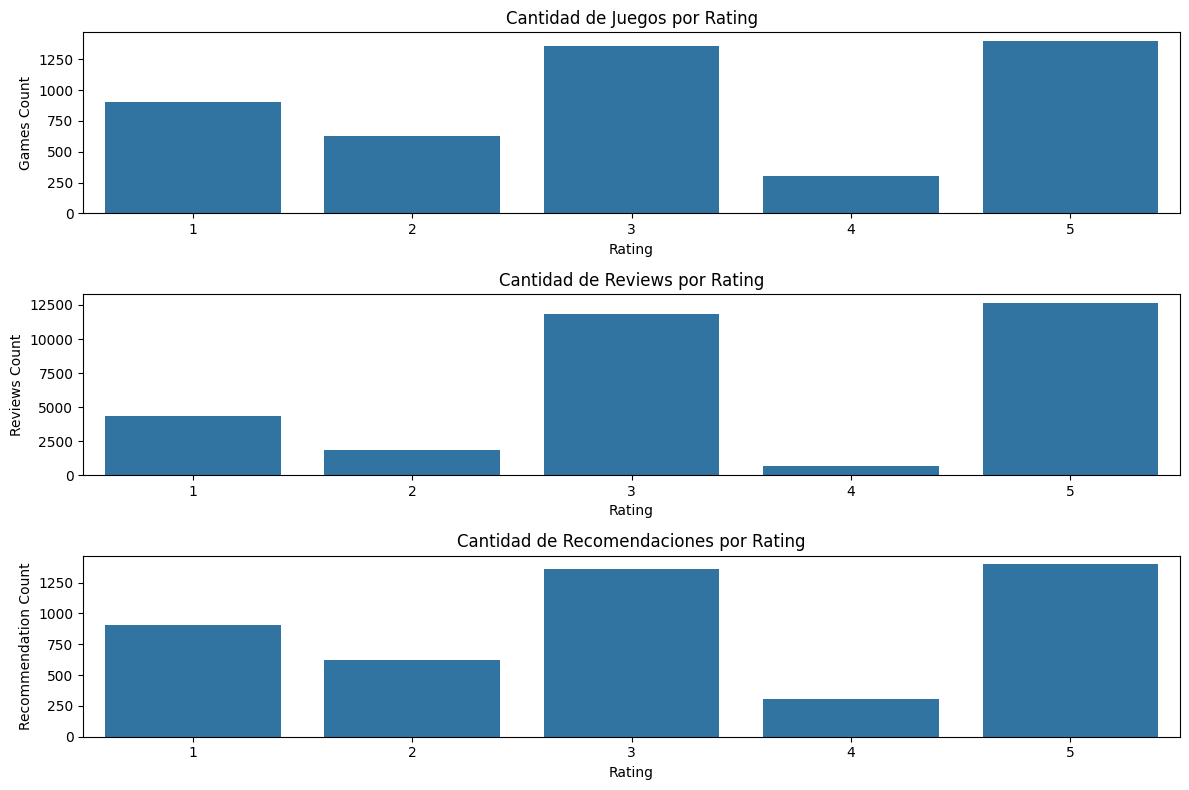

In [11]:
rating_counts = merged_data.groupby("recommendation")["item_id"].nunique()
review_counts = merged_data.groupby("recommendation")["user_id"].count()
game_counts = merged_data.groupby("recommendation")["item_name"].nunique()
print(rating_counts)
print(review_counts)
print(game_counts)

summary_df = pd.DataFrame({
    "Rating": rating_counts.index,
    "Games Count": game_counts.values,
    "Reviews Count": review_counts.values,
    "Recommendation Count": rating_counts.values
})

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
sns.barplot(x="Rating", y="Games Count", data=summary_df)
plt.title("Cantidad de Juegos por Rating")

plt.subplot(3, 1, 2)
sns.barplot(x="Rating", y="Reviews Count", data=summary_df)
plt.title("Cantidad de Reviews por Rating")

plt.subplot(3, 1, 3)
sns.barplot(x="Rating", y="Recommendation Count", data=summary_df)
plt.title("Cantidad de Recomendaciones por Rating")

plt.tight_layout()
plt.show()

## 6. Crear DataFrame con Recommendation Normalizados

In [41]:
# Copiamos el dataframe de nuestro interes pero sin la columna item_id ya que no es relevante
df_final = merged_data[["user_id","item_id","recommendation"]]
df_final

,user_id,item_id,recommendation
0,76561197970982479,1250,5
1,death-hunter,1250,5
2,DJKamBer,1250,3
3,diego9031,1250,3
4,76561198081962345,1250,3
...,...,...,...
31309,K1NGCJS,294230,3
31310,laislabonita75,305920,1
31311,Gamer0009,306040,5
31312,llDracuwulf,307130,3


In [42]:
table_ = df_final.pivot_table(index=["user_id"], columns=["item_id"], values="recommendation")
table_

item_id,20,30,40,60,400,500,550,620,1250,1510,...,506590,509840,510050,512300,512630,516040,521340,521430,521570,521990
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ace--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ionex--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Azsael-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Beave-,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zv_odd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zvanik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zynxgameth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Normalizamos nuestra dataframe para poder ser analizado posteriormente en el modelo
normalized_df = table_.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
normalized_df.fillna(0, inplace=True)
normalized_df = normalized_df.T
normalized_df = normalized_df.loc[:, (normalized_df != 0).any(axis=0)]
normalized_df

user_id,-PRoSlayeR-,-SEVEN-,-_PussyDestroyer_-,01189958889189157253,04061993,07846813956825,09106,091263,095732,098766catdogbnmnnn,...,zombieskiler6969,zomgieee,zp3413,zrustz16,zsharoarkbr,zuilde,zuzuga2003,zv_odd,zvanik,zyr0n1c
item_id,,,,,,,,,,,,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
normalized_df.shape

(2168, 5127)

In [45]:
# Convertimos el DataFrame normalizado a una matriz dispersa para eficiencia en grandes conjuntos de datos.
sparse_matrix = sp.csr_matrix(normalized_df.values)
sparse_matrix

<2168x5127 sparse matrix of type '<class 'numpy.float64'>'
	with 16484 stored elements in Compressed Sparse Row format>

## 7.Calcular Matrices de Similitud

Utilizamos la similitud del coseno para calcular la similitud entre juegos (item-item) y usuarios (user-user). Se utiliza para determinar cuán similares son dos conjuntos de datos o elementos.

In [46]:
item_similarity = cosine_similarity(sparse_matrix)
user_similarity = cosine_similarity(sparse_matrix.T)

## 8. Estructurar Resultados en DataFrame

Creamos DataFrames para organizar y estructurar las matrices de similitud entre juegos y usuarios.

In [47]:
item_similarity_df = pd.DataFrame(item_similarity, index=normalized_df.index, columns=normalized_df.index)
user_similarity_df = pd.DataFrame(user_similarity, index=normalized_df.columns, columns=normalized_df.columns)

In [48]:
item_similarity_df

item_id,20,30,40,60,400,500,550,620,1250,1510,...,506590,509840,510050,512300,512630,516040,521340,521430,521570,521990
item_id,,,,,,,,,,,,,,,,,,,,,
20,1.000000,0.000000,0.0,0.000000,-0.029217,0.0,0.010429,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.000000,1.000000,0.0,-0.305058,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.000000,-0.305058,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400,-0.029217,0.000000,0.0,0.000000,1.000000,0.0,-0.017960,-0.047384,0.003424,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516040,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
521340,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
521430,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
user_similarity_df

user_id,-PRoSlayeR-,-SEVEN-,-_PussyDestroyer_-,01189958889189157253,04061993,07846813956825,09106,091263,095732,098766catdogbnmnnn,...,zombieskiler6969,zomgieee,zp3413,zrustz16,zsharoarkbr,zuilde,zuzuga2003,zv_odd,zvanik,zyr0n1c
user_id,,,,,,,,,,,,,,,,,,,,,
-PRoSlayeR-,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
-SEVEN-,0.0,1.000000,0.0,0.144338,0.0,0.612372,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.00000,0.144338,0.0,0.0,-0.471405,0.0,0.0,0.0
-_PussyDestroyer_-,0.0,0.000000,1.0,0.000000,0.5,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
01189958889189157253,0.0,0.144338,0.0,1.000000,0.0,0.353553,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.00000,0.250000,0.0,0.0,0.000000,0.0,0.0,0.0
04061993,0.0,0.000000,0.5,0.000000,1.0,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.00000,0.000000,0.5,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuilde,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,...,-0.5,0.000000,0.00000,-0.353553,0.0,1.0,0.000000,0.0,0.0,0.0
zuzuga2003,0.0,-0.471405,0.0,0.000000,0.0,-0.577350,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0
zv_odd,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0


## 9. Funcion recomendacion_juego

Ingresando el id de producto con esta funcion recibiremos una lista con 5 juegos recomendados similares al ingresado.

In [72]:
def juegos_similares_por_id(id_juego, item_similarity_df, unique_games):
    if id_juego not in item_similarity_df.index:
        raise ValueError(f"Juego con ID {id_juego} no encontrado en la matriz de similitud.")
    similitudes = item_similarity_df.loc[id_juego].sort_values(ascending=False)[1:6]
    juegos_similares = unique_games.loc[unique_games["item_id"].isin(similitudes.index), "item_name"].tolist()
    print(f"Juegos similares al juego con ID {id_juego} incluyen:")
    for i, juego in enumerate(juegos_similares, start=1):
        print(f"{i}. {juego}")



In [71]:
id_ejemplo = 1250  
juegos_similares_por_id(id_ejemplo,item_similarity_df=item_similarity_df,unique_games=unique_games)

Juegos similares al juego con ID 1250 incluyen:
1. Unreal Gold
2. Shank
3. Lucius II
4. Star Trek Online
5. The Mystery of the Druids


Despues de varios intentos no se logro crear una funcion donde solo el parametro entregado sea el item_id y que devuelva un resultado coherente dado que daba una lista vacia por lo que la solucion que se pudo hallar fue darle dos parametros en los cuales estan los dataframes con la informacion necesaria

## 10. Cargamos los archivos en formato PARQUET

In [60]:
archivo1 = "data2/item_similarity_df_final1.csv"
item_similarity_df.to_csv(archivo1, index=False, encoding="utf-8")
print(f"Se guardó el archivo {archivo1}") 

Se guardó el archivo data2/item_similarity_df_final1.csv


In [61]:
archivo2 = "Datasets/item_similarity_df_final1.parquet"
item_similarity_df.to_parquet(archivo2, index=False)
print(f"Se guardó el archivo {archivo2}")

Se guardó el archivo Datasets/item_similarity_df_final1.parquet


In [62]:
archivo3 = "data2/unique_games_final1.csv"
unique_games.to_csv(archivo3, index=False, encoding="utf-8")
print(f"Se guardó el archivo {archivo3}") 

Se guardó el archivo data2/unique_games_final1.csv


In [63]:
archivo4 = "Datasets/unique_games_final1.parquet"
unique_games.to_parquet(archivo4, index=False)
print(f"Se guardó el archivo {archivo4}")

Se guardó el archivo Datasets/unique_games_final1.parquet
